# Asset Pricing

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

## Lucas Tree Model:

In [2]:
class LucasTree:
    '''
    A LucasTree class to implement the Model.
    Has only one attribute -> data
    Has methods to estimate gamma & beta.
    '''
    def __init__(self, data, beta=1e9):
        # Set default value of beta & gamma to be very high for the case where they have to be estimated
        self.data = data
        if beta!=1e9:
            self.beta = beta          # Beta given 
        else:
            self.beta = float('NaN')  # Beta not given
        
    def get_m(self, beta, gamma):
        temp = self.data.consm / self.data.consm.shift(1)  
        m = beta * temp**(-gamma)
        m = m.dropna()
        return m
    
    def get_R(self):
        temp = self.data.mkt/self.data.deflator
        R = temp / temp.shift(1)
        R = R.dropna()
        return R
    
    def get_Rf(self):
        temp = (self.data.deflator/self.data.deflator.shift(1)) - 1
        Rf = 1 + ((self.data.Tbill/100) - temp)
        Rf = Rf.dropna()
        return Rf
    
    def func1(self, gamma):
        m = self.get_m(self.beta, gamma)
        R = self.get_R()
        covar = m.cov(R)
        error = covar + m.mean()*R.mean() - 1
        return error
    
    def func3(self, gamma):
        m = self.get_m(self.beta, gamma)
        Rf = self.get_Rf()
        error = m.mean()*Rf.mean() - 1
        return error
    
    def func4(self, args):
        beta = args[0]
        gamma = args[1]
        m = self.get_m(beta, gamma)
        R = self.get_R()
        Rf = self.get_Rf()
        covar = m.cov(R)
        err1 = m.mean() * Rf.mean() - 1
        err2 = covar + m.mean()*R.mean() - 1
        error = [err1, err2]
        return error
    
    def get_gamma(self, guess, q=1):
        # for Q1, func1 is the euler eq, for Q3, func3 is
        if q==3:
            results = opt.broyden1(self.func3, guess, f_tol=1e-4)
        else:
            results = opt.broyden1(self.func1, guess, f_tol=1e-4)
        gamma = results[0]
        return gamma
    
    def get_bg(self, guess):
        # for Q4, func4 is the euler eq
        results = opt.broyden1(self.func4, guess, f_tol=1e-4)
        beta = results[0]
        gamma = results[1]
        return (beta, gamma)
    
    def plot(self):
        n = 50
        N = 5
        g_grid = np.linspace(0, 5, n)
        b_grid = np.linspace(0.95, 0.99, N)

        plot_y = np.zeros((n, N))
        for i in range(n):
            for j in range(N):
                #args = [b_grid[j], g_grid[i]]
                args = np.array([b_grid[j], g_grid[i]])
                #(beta, gamma) = get_bg(args)
                plot_y[i, j] = self.func4(args)[1]
                
        fig = plt.figure(figsize=(10, 6))
        for j in range(N):
            plt.plot(g_grid, plot_y[:, j], label=("Beta= "+ str(b_grid[j])))
        plt.title('Value of GMM objective function')
        plt.xlabel("Gamma")
        plt.legend()
        plt.show()

In [3]:
# read data from file
df_consm = pd.read_csv("Data\PCECC96.csv")
df_mkt = pd.read_csv("Data\WILL5000INDFC.csv")
df_dfltr = pd.read_csv("Data\GDPDEF.csv")
df_Tbill = pd.read_csv("Data\TB3MS.csv")
# merge all the data
df_all = df_consm.merge(df_mkt, on="DATE", how='inner')
df_all = df_all.merge(df_dfltr, on="DATE", how='inner')
df_all = df_all.merge(df_Tbill, on="DATE", how='inner')
df_all = df_all.rename(columns={"PCECC96": "consm", "WILL5000INDFC": "mkt", "GDPDEF": "deflator", "TB3MS": "Tbill"})

### Ques 1

In [4]:
# set beta
beta = 0.99

# Instanciate the LucasTree object
lucas1 = LucasTree(data=df_all, beta=beta)
gamma = lucas1.get_gamma(guess=[0.5])
print("Gamma = ", gamma)

Gamma =  1.1621951335073393


### Ques 2

The method should be tried with different samples of data and different values of $\beta$ to check whether we get consistent estimates of $\gamma$. Also, the other equation (i.e. equation 7 of the notes) can be used to estimate $\gamma$ and this can be compared to the current estimate to check for the reasonableness of the parameters.

### Ques 3

In [5]:
# set beta
beta = 0.99

# Instanciate the LucasTree object
lucas3 = LucasTree(data=df_all, beta=beta)
gamma = lucas3.get_gamma(guess=[0.5], q=3)
print("Gamma = ", gamma)

Gamma =  3.7185754120177825


### Ques 4

Beta=  0.18753526855075076 Gamma=  -159.9668719469684 



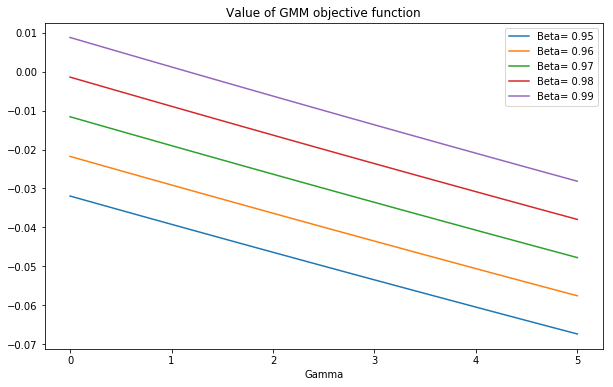

In [6]:
# Instanciate the LucasTree object
lucas4 = LucasTree(data=df_all)
(beta, gamma) = lucas4.get_bg(guess=[1, 1])
print("Beta= ", beta, "Gamma= ", gamma, "\n")
lucas4.plot()

## The Kyle model of orderbook shape:

In [7]:
class KyleOrderbook:
    '''
    KyleOrderbook class to implement the Kyle orderbook model
    Has attributes data, name and delta. The default value of delta is set at 10%
    '''
    def __init__(self, data, name, delta=0.10):
        self.timestamp = data[0]
        self.name = name
        
        # Data preparation
        df = pd.DataFrame.from_dict(data[1], orient='index').sort_index()
        df.columns = ["Qty", "Side", "Col4", "Col5"]
        df = df[["Qty", "Side"]]
        
        # separate buy & sell orders to get cumulative quantities
        buy = df[df.Side == 'B'].sort_index(ascending=False)
        p_bid = buy.index[0]                                # Highest buy price
        sell = df[df.Side == 'S'].sort_index()
        buy["CB"] = -buy.Qty.cumsum()
        sell["CS"] = sell.Qty.cumsum()
        # merge buy & sell to get the final orderbook
        df = pd.concat([buy.sort_index(), sell], sort=True)
        df = df.fillna(0)
        df["CQ"] = df.CB + df.CS
        
        # set processed data as self.data
        self.p0 = p_bid
        self.data = df
        # data within the range of +/- delta of the p_bid
        self.orderbook = df[(df.index >= p_bid*(1-delta)) & (df.index <= p_bid*(1+delta))]
        
    def estimate(self):
        P = self.orderbook.index.values
        Q = self.orderbook.CQ
        results = ols("Q ~ P", self.orderbook).fit()
        # result = smf.ols(formula='Cumulative_Quantity ~ Price', data=orderbook).fit()
        gamma = results.params[0]
        beta = results.params[1]
        return (beta, gamma)

    def plot(self):
        x = self.orderbook.index.values
        y = self.orderbook.CQ
        plt.plot(x, y, label="Original")
        obook = self.orderbook
        (beta, gamma) = self.estimate()
        x1 = self.orderbook.index.values
        y1 = gamma + beta*x1
        plt.plot(x1, y1, label="Estimate")
        plt.xlabel('Price')
        plt.ylabel('Cumulative Quantity')
        plt.title("Orderbook of Stock " + self.name + " at t = " +  str(self.timestamp))
        plt.legend()
        plt.show()


In [8]:
# read data from file
df_AAPL = pd.read_pickle("Data\AAPL")
df_C = pd.read_pickle("Data\C")
df_GBX = pd.read_pickle("Data\GBX")
df_SPY = pd.read_pickle("Data\SPY")
df_THO = pd.read_pickle("Data\THO")

### Ques 1

Estimates:
 Beta =  244050.1553743498  Gamma =  -35817276.486975744


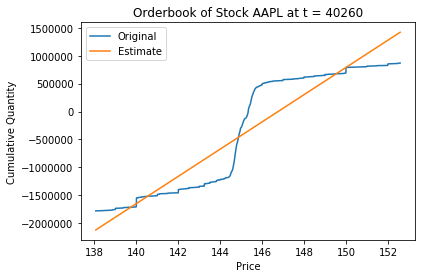

Estimates:
 Beta =  684403.5559234768  Gamma =  -46336992.920248106


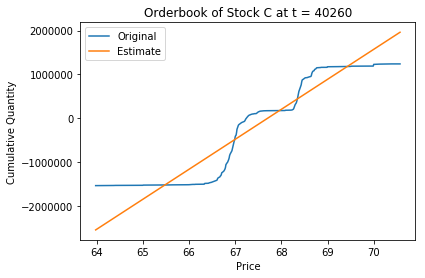

Estimates:
 Beta =  31708.05772250166  Gamma =  -1374568.8010156099


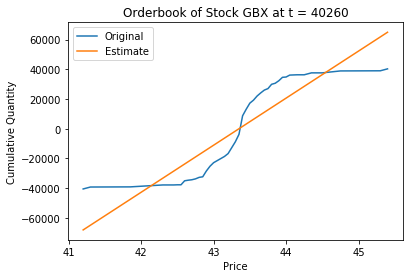

Estimates:
 Beta =  298227.003868606  Gamma =  -73892997.45534948


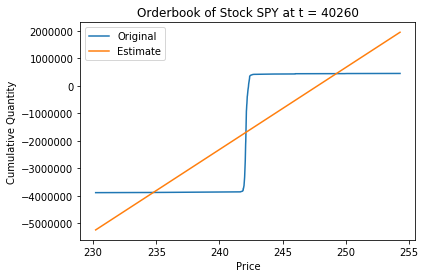

Estimates:
 Beta =  49768.755089603015  Gamma =  -5049428.765766624


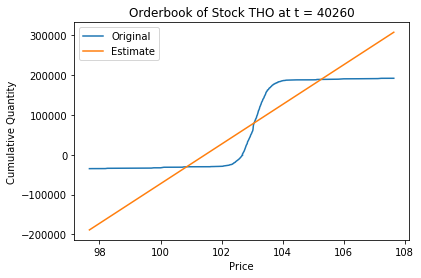

In [9]:
# Make a dictionary of the dataset
dict_data = {"AAPL": df_AAPL, "C": df_C, "GBX": df_GBX, "SPY": df_SPY, "THO": df_THO}

delta = 0.05

# instantiate the KyleOrderbook class for each stock
for name in dict_data:
    df = dict_data[name]
    kob = KyleOrderbook(df[100], name, delta=delta)
    (beta, gamma) = kob.estimate()
    print("Estimates:\n", "Beta = ", beta, " Gamma = ", gamma)
    kob.plot()

From the plots it is pretty clear that the model fits best near the centre where as it is way off towards the end points. Therefore, one might want to estimate using subset of the orderbook towards the mid point

### Ques 2

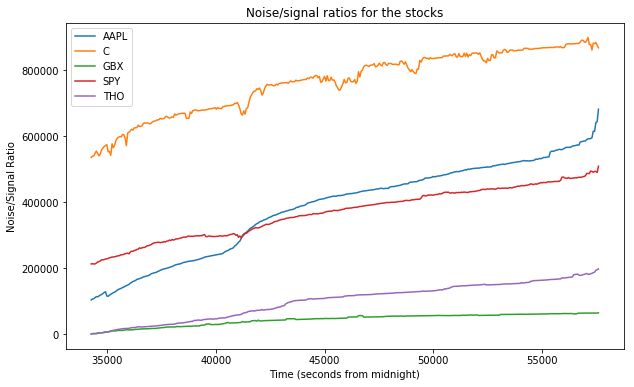

In [10]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

# instantiate the KyleOrderbook class for each stock for each timstamp 
for name in dict_data:
    delta = 0.05
    df = dict_data[name]
    plot_x = np.zeros(len(df))
    plot_y = np.zeros_like(plot_x)
    for i in range(len(df)):
        kob = KyleOrderbook(df[i], name, delta=delta)
        (beta, gamma) = kob.estimate()
        plot_x[i] = kob.timestamp
        
        # The ratio to be plotted is equal to beta_hat
        plot_y[i] = beta
    
    ax.plot(plot_x, plot_y, label=name)
plt.xlabel("Time (seconds from midnight)")
plt.ylabel("Noise/Signal Ratio")
plt.title("Noise/signal ratios for the stocks")
plt.legend()
plt.show()

### Ques 3

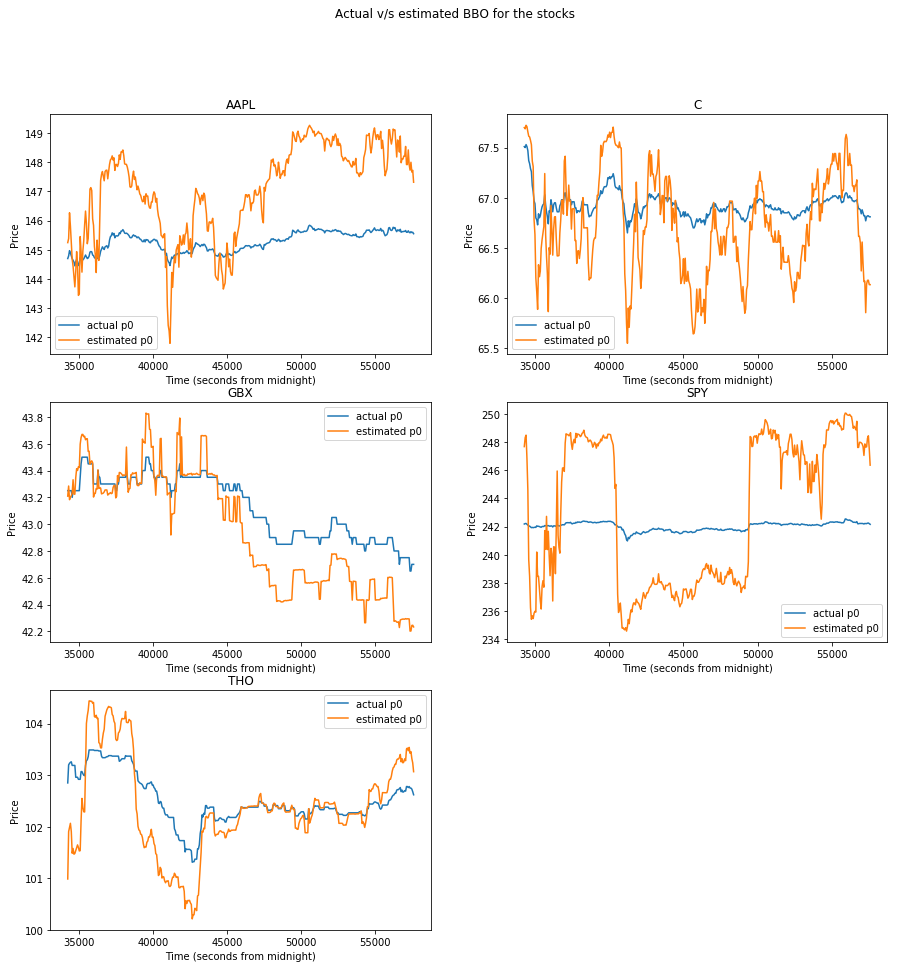

In [11]:
fig = plt.figure(figsize=(15,15))

# instantiate the KyleOrderbook class for each stock for each timstamp 
for l, name in enumerate(dict_data):
    delta = 0.05
    df = dict_data[name]
    plot_x = np.zeros(len(df))
    plot_y = np.zeros_like(plot_x)
    plot_y1 = np.zeros_like(plot_x)
    for i in range(len(df)):
        kob = KyleOrderbook(df[i], name, delta=delta)
        (beta, gamma) = kob.estimate()
        plot_x[i] = kob.timestamp
        
        # actual p0
        plot_y[i] = kob.p0
        
        # estimated p0
        plot_y1[i] = -gamma/beta
    ax = fig.add_subplot(3,2,l+1)
    ax.plot(plot_x, plot_y, label="actual p0")
    ax.plot(plot_x, plot_y1, label="estimated p0")
    ax.set_xlabel("Time (seconds from midnight)")
    ax.set_ylabel("Price")
    ax.set_title(name)
    ax.legend()

plt.suptitle("Actual v/s estimated BBO for the stocks")
#plt.tight_layout()
plt.show()

### Ques 4
For each of the stocks the estimated price appears to be more fluctuating than the actual price